# Diffusion Process on CelebA Dataset
In this notebook, we will explore the diffusion process using the CelebA dataset. We will start by defining the variance schedule and implementing the forward process.

PyTorch have some issue in downloading Celeba automatically so it is likely that you had to download the dataset manually from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html.

The dataset file needed should be placed in the data folder and should have this structure:

<img src="images/celeba_dt.png" width="50%">


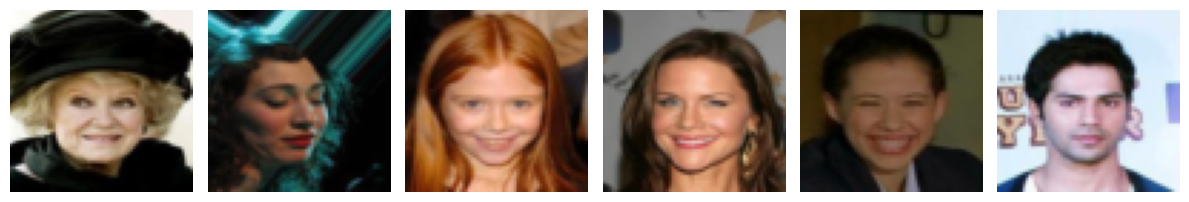

Image size: torch.Size([3, 64, 64])


In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from src.diffusion import DiffusionProcess
from torch.utils.data import Subset
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"  # Set to the GPU you want to use

# Define the transformation for the dataset - resize to 48x48
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize CelebA images to 64x64
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Download and load the CelebA dataset (download=False because we already have it)
dataset = datasets.CelebA(root='data', split="test", download=False, transform=transform)

# Visualize some images from the training dataset
def plot_celeba_samples(dataset, num_samples=6):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i in range(num_samples):
        image, _ = dataset[i]
        # Convert from [-1, 1] to [0, 1] range for visualization
        img = (image.permute(1, 2, 0) + 1) / 2
        axes[i].imshow(img.clamp(0, 1))
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Plot some samples
plot_celeba_samples(dataset)

# Print dataset structure
print(f"Image size: {dataset[0][0].shape}")

## Variance Schedule: Linear Schedule
The variance schedule controls the amount of noise added at each step of the forward process. For a linear schedule, the variance $\beta_t$ at timestep $t$ is defined as:

$$\beta_t = \beta_1 + t \cdot \frac{\beta_T - \beta_1}{T - 1}$$

where $\beta_1$ and $\beta_T$ are the minimum and maximum noise levels, and $T$ is the total number of timesteps.

Variance schedule: tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04,
        2.1952e-04, 2.3944e-04, 2.5936e-04, 2.7928e-04])


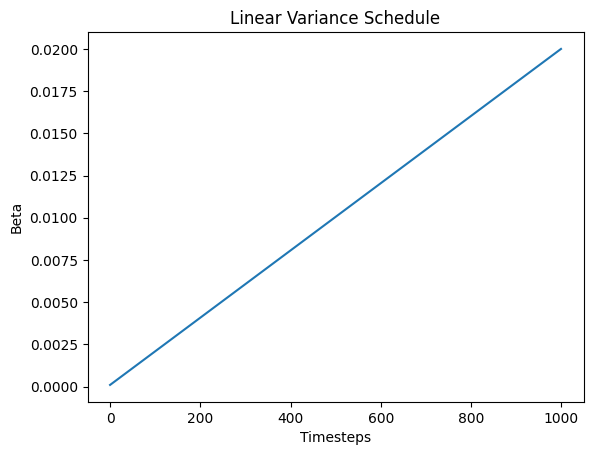

In [2]:
# Define the variance schedule
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    """Define the variance schedule"""
    return torch.linspace(beta_start, beta_end, timesteps)

# Example usage
timesteps = 1000
beta_schedule = linear_beta_schedule(timesteps)
print(f"Variance schedule: {beta_schedule[:10]}")

# Plot the variance schedule
plt.plot(beta_schedule.numpy())
plt.title("Linear Variance Schedule")
plt.xlabel("Timesteps")
plt.ylabel("Beta")
plt.show()

## Forward Process
The forward process gradually adds noise to the data. At each timestep $t$, the noisy data $\mathbf{x}_t$ is generated using the formula:

$$\mathbf{x}_t = \sqrt{\bar{\alpha}_t} \mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t} \boldsymbol{\epsilon}$$

where $\boldsymbol{\epsilon} \sim \mathcal{N}(0, \mathbf{I})$ is Gaussian noise, and $\bar{\alpha}_t$ is the cumulative product of $1 - \beta_t$.

## Visualizing the Forward Diffusion Process

Let's visualize how images get progressively noisier during the forward diffusion process. We'll take some sample images from our dataset and show what they look like at different timesteps $t$.

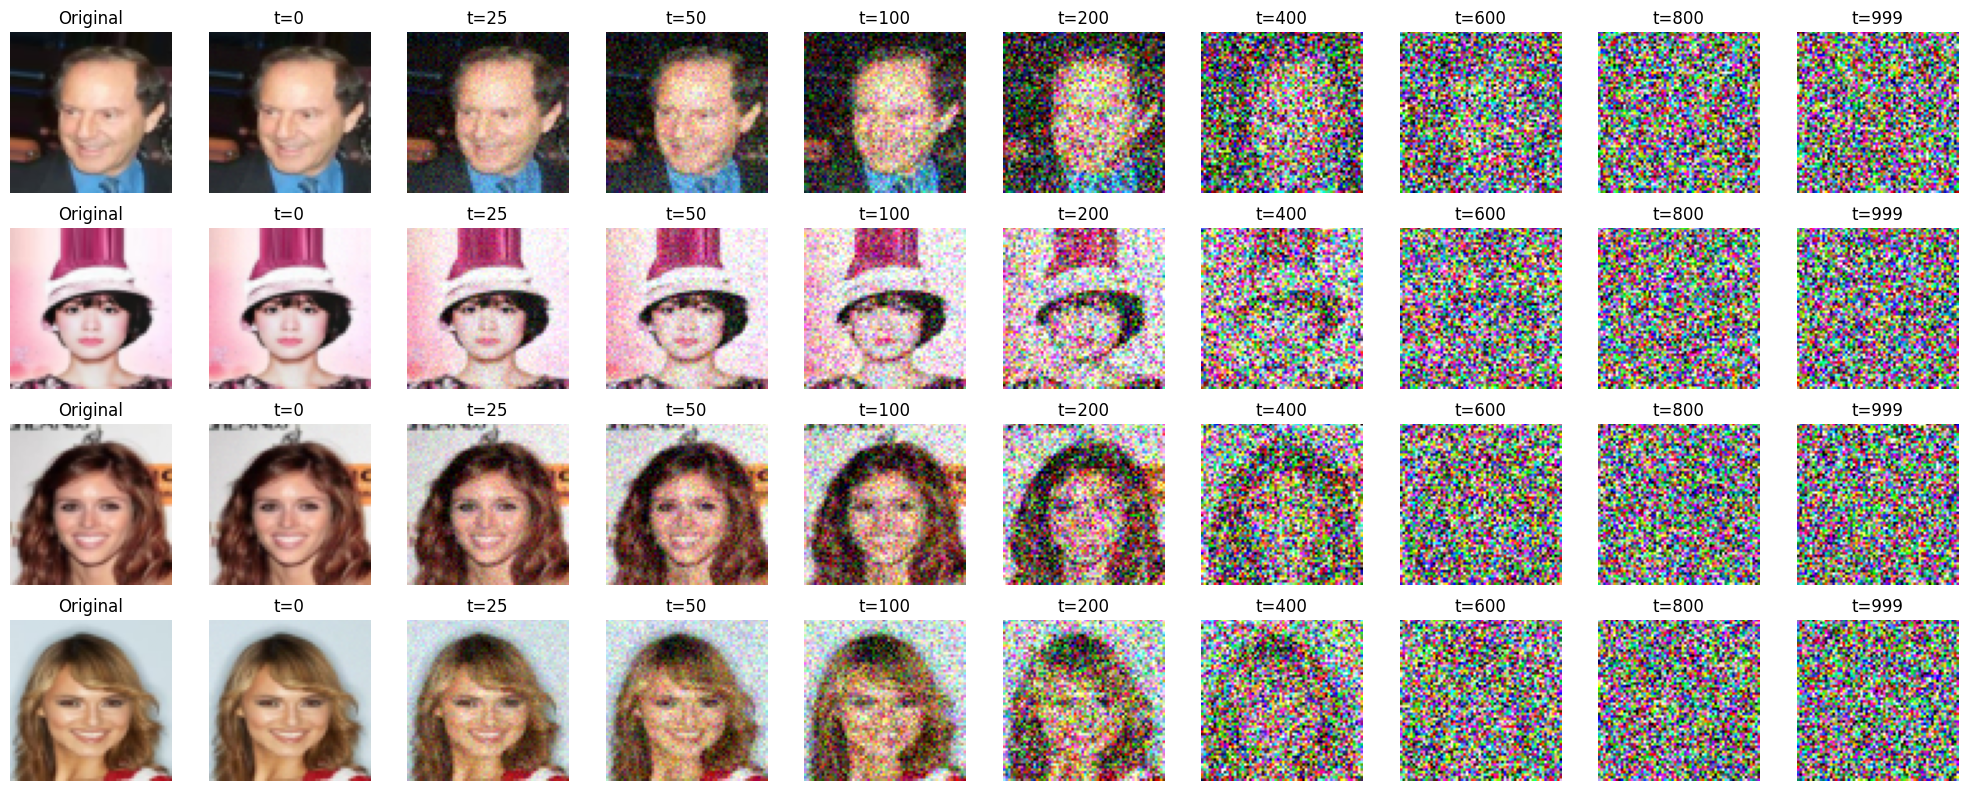

The visualization shows how CelebA face images gradually become more noisy as we progress through the timesteps.
At t=0, we have the original images, and by the final timestep, the images are almost pure noise.


In [3]:
from src.training import visualize_forward_diffusion

# Initialize diffusion process
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
beta_schedule = linear_beta_schedule(1000, beta_end=0.02).to(device)
diffusion = DiffusionProcess(beta_schedule)

# Get some sample images
num_samples = 4
sample_indices = torch.randint(0, len(dataset), (num_samples,))
sample_images = torch.stack([dataset[i][0] for i in sample_indices])

# Visualize the forward process
visualize_forward_diffusion(
    diffusion, sample_images, 
    steps=[0, 25, 50, 100, 200, 400, 600, 800, 999], 
    device=device
)

print("The visualization shows how CelebA face images gradually become more noisy as we progress through the timesteps.")
print("At t=0, we have the original images, and by the final timestep, the images are almost pure noise.")

## UNet Model from Diffusers Library

For the CelebA dataset, we'll use a more powerful UNet model from the `diffusers` library. This model includes attention mechanisms which are particularly helpful for generating high-quality images.

In [4]:
from src.models.unet import UNet

# --- Model params for Our Unet ---
unet_args = {
    'input_channel': 3,
    'base_channel': 128,
    'channel_multiplier': [1, 2, 3, 4],
    'num_residual_blocks_of_a_block': 2,
    'attention_resolutions': [3, 4],
    'num_heads': 1,
    'head_channel': -1,
    'use_new_attention_order': False,
    'dropout': 0.1,
    'dims': 2
}

model = UNet(**unet_args).to(device)

model_path = "experiments/celeba64x64v2/checkpoints/checkpoint_last.pth"
if os.path.exists(model_path):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print("Model loaded successfully.")
else:
    print(f"Model checkpoint not found at {model_path}. Please check the path.")
    raise FileNotFoundError(f"Model checkpoint not found at {model_path}.")
# Set the model to evaluation mode
model.eval()

Model loaded successfully.


UNet(
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepSequential(
      (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=512, out_features=256, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm(32, 128, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pa

## Generating Samples with the Trained Model

Now that we've loaded our pretrained model, let's generate some samples to see how well it learned to model the data distribution.

DDPM Sampling: 1000it [02:15,  7.37it/s]


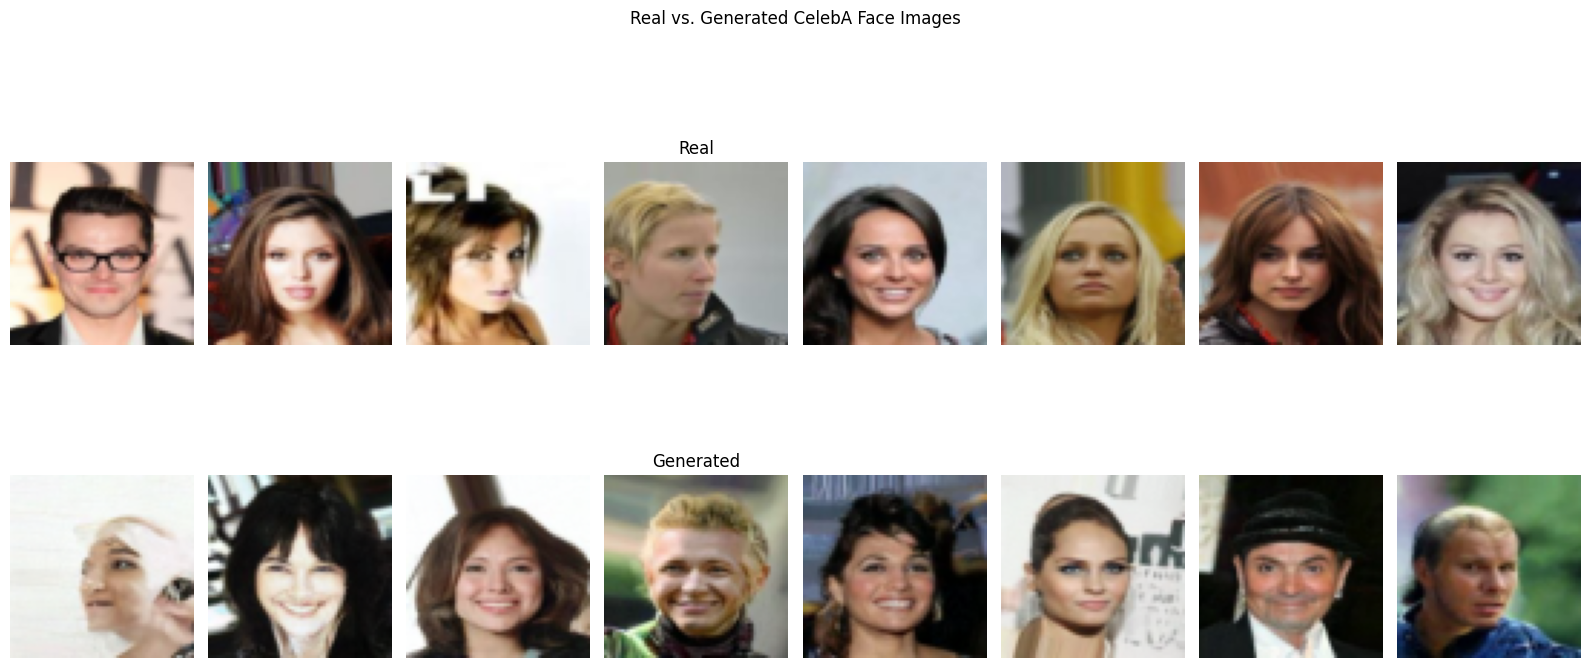

In [5]:
# Get some real samples for comparison
real_indices = torch.randint(0, len(dataset), (8,))
real_samples = torch.stack([dataset[i][0] for i in real_indices])

# Generate the same number of samples
generated_samples = diffusion.sample(model, n_samples=8, device=device, size=(3, 64, 64))

# Display comparison
plt.figure(figsize=(16, 8))

# Show real samples
for i in range(8):
    plt.subplot(2, 8, i+1)
    img_real = (real_samples[i].cpu().permute(1, 2, 0) + 1) / 2
    plt.imshow(img_real.clamp(0, 1))
    plt.title("Real" if i == 3 else "")
    plt.axis('off')

# Show generated samples
for i in range(8):
    plt.subplot(2, 8, 8+i+1)
    img_gen = (generated_samples[i].cpu().permute(1, 2, 0) + 1) / 2
    plt.imshow(img_gen.clamp(0, 1))
    plt.title("Generated" if i == 3 else "")
    plt.axis('off')

plt.suptitle("Real vs. Generated CelebA Face Images")
plt.tight_layout()
plt.show()

## Conclusion

In this notebook, we:

1. Set up the CelebA dataset and visualized sample images
2. Defined a linear variance schedule for the diffusion process
3. Visualized how images get progressively noisier in the forward diffusion process
4. Used a pretrained UNet model with our training engine from src.training.py
6. Generated samples from the trained modela and compared them with real images

The quality of the generated samples shows how well the diffusion model learned to model the complex distribution of human faces. This is just a starting point - with more training time or an EMA weights update strategy, we could further improve the quality of the generated images. 

## DDIM Sampling with Fewer Steps

DDIM (Denoising Diffusion Implicit Models) allows us to sample high-quality images in fewer steps than traditional DDPM. Let's implement DDIM sampling with 50 steps for CelebA images.

Generating samples using DDIM with 101 steps...


DDIM Sampling: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


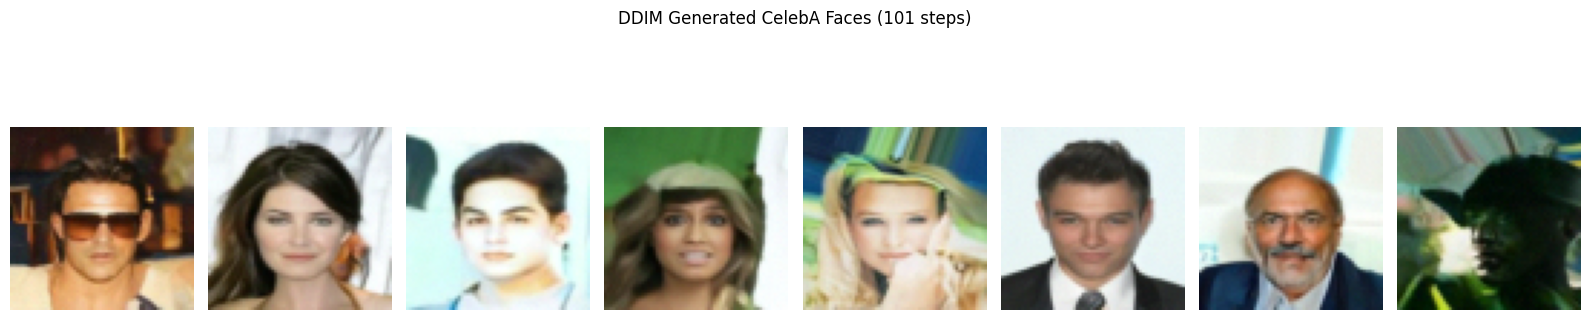

In [6]:
# Initialize DDIM process
from src.diffusion import DDIM

ddim_process = DDIM(beta_schedule)

# Set number of DDIM steps
N_ddim_steps = 100

# Create a subset of timesteps for accelerated sampling
full_timesteps = diffusion.timesteps
step_size = full_timesteps // N_ddim_steps
timestep_subset = list(range(full_timesteps - 1, -1, -step_size))
# Ensure the last step (t=0) is included
if timestep_subset[-1] != 0:
    timestep_subset.append(0)

# Generate samples using DDIM
print(f"Generating samples using DDIM with {len(timestep_subset)} steps...")
ddim_samples = ddim_process.sample_ddim(
    model, 
    n_samples=8, 
    device=device, 
    size=(3, 64, 64),
    timestep_subset=timestep_subset,
    eta=0.0  # Deterministic DDIM
)

# Display results
plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(1, 8, i+1)
    img_gen = (ddim_samples[i].cpu().permute(1, 2, 0) + 1) / 2
    plt.imshow(img_gen.clamp(0, 1))
    plt.axis('off')
    
plt.suptitle(f"DDIM Generated CelebA Faces ({len(timestep_subset)} steps)")
plt.tight_layout()
plt.show()

## Classifier Guidance with ResNet-18

Classifier guidance can steer the diffusion process toward generating images with specific attributes. For CelebA, we'll use a pre-trained ResNet-18 model to guide the generation toward faces with specific attributes.

In [7]:
import torchvision
from torch import nn
from tqdm import tqdm

classifier_path = "models/celeba_classifier.pth"

# Look at the attributes of the CelebA dataset
print(dataset.attr_names[:])  # Display the first 10 attribute names
len(dataset.attr_names)  # Total number of attributes

num_classes = len(dataset.attr_names) - 1  # Number of classes (attributes)
print(f"Number of classes: {num_classes}")

class CelebaClassifier(torch.nn.Module):
    def __init__(self, num_classes=40):
        super().__init__()
        self.net = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        self.net.fc = torch.nn.Linear(self.net.fc.in_features, num_classes)

    def forward(self, x):
        return self.net(x)
    
classifier = CelebaClassifier(num_classes=num_classes).to(device)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young', '']
Number of classes: 40


In [8]:
def train_classifier(classifier, diffusion_process, dataloader, epochs=5, lr=1e-3):
    optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # Ensure the model is in training mode
    classifier.train()

    print("Starting classifier training...")
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (images, labels) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
            images = images.to(device)
            labels = labels.float().to(device)
            
            # Add random noise to images
            # Sample a random timestep for each image in the batch
            t = torch.randint(0, diffusion_process.timesteps, (images.shape[0],), device=device).long()
            # Use corrupt_image instead of forward_diffusion
            noisy_images, _ = diffusion_process.corrupt_image(images, t) 
            
            optimizer.zero_grad()
            outputs = classifier(noisy_images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

    print("Classifier training finished.")
    # Save the trained classifier
    torch.save(classifier.state_dict(), classifier_path)
    print(f"Classifier saved to {classifier_path}")

# Check if a pre-trained classifier exists
if os.path.exists(classifier_path):
    print(f"Loading pre-trained classifier from {classifier_path}")
    classifier.load_state_dict(torch.load(classifier_path, map_location=device))
    classifier.eval() # Set to evaluation mode
else:
    print("No pre-trained classifier found. Training a new one...")
    # Create a DataLoader for training the classifier
    # Using a larger batch size for classifier training is common
    classifier_train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    train_classifier(classifier, diffusion, classifier_train_loader, epochs=50) # Train for more epochs if needed
    classifier.eval() # Set to evaluation mode after training

Loading pre-trained classifier from models/celeba_classifier.pth


## Classifier-Guided Generation with CelebA Attributes

Having trained a classifier on CelebA attributes, we can now use it to guide the diffusion process towards generating images with specific attributes. Let's create a classifier-guided DDIM sampling function similar to what we did in the guidance notebook but adapted for CelebA attributes.

We'll implement a function to generate female faces by applying negative guidance on the "Male" attribute.

In [9]:
import torch.nn.functional as F

def classifier_guided_sample_ddim_celeba(
    model,            # The UNet model
    ddim_process,      # The DDIM instance
    classifier,        # The CelebA attribute classifier
    n_samples,         # Number of samples to generate
    device,            # Device to use
    size=(3, 64, 64),  # Image size
    target_attr_idx=20, # Index of the target attribute (20 is 'Male' in CelebA)
    guidance_scale=-3.0, # Negative for female (opposite of male), positive for male
    N_ddim_steps=100,  # Number of DDIM steps
    eta=0.0            # DDIM stochasticity parameter
):
    model.eval()
    classifier.eval()
    
    # Start from pure noise
    img = torch.randn((n_samples, *size), device=device)
    history = [] # To store some intermediate images for visualization
    
    # Create a subset of timesteps for accelerated sampling
    full_timesteps = ddim_process.timesteps
    step_size = full_timesteps // N_ddim_steps
    timestep_subset = list(range(full_timesteps - 1, -1, -step_size))
    # Ensure the last step (t=0) is included
    if timestep_subset[-1] != 0:
        timestep_subset.append(0)
    timestep_subset = torch.tensor(timestep_subset, device=device)
    
    # Convert to tensor for batching
    for i in tqdm(range(len(timestep_subset) - 1), desc="DDIM Classifier-Guided Sampling"):
        t_idx = timestep_subset[i]
        t_next_idx = timestep_subset[i + 1]
        
        # We need gradients for the input to the classifier
        img_for_classifier = img.detach().requires_grad_(True)
        
        # 1. Get classifier's prediction for the target attribute
        logits = classifier(img_for_classifier)
        log_probs = F.log_softmax(logits, dim=-1) 
        
        # For the 'Male' attribute (index 20), get log probability
        selected_log_probs = log_probs[:, target_attr_idx]
        
        # 2. Compute gradient of the log probability with respect to input
        gradient = torch.autograd.grad(selected_log_probs.sum(), img_for_classifier)[0]
        
        # 3. Get unconditional noise prediction
        with torch.no_grad():
            t_tensor = torch.full((n_samples,), t_idx, device=device, dtype=torch.long)
            noise_pred_uncond = model(img, t_tensor)
        
        # 4. Apply classifier guidance (negative scale for opposite attribute - to generate females)
        noise_pred_guided = noise_pred_uncond - guidance_scale * gradient
        
        # 5. Use DDIM sampling with the guided noise prediction
        img = ddim_process.ddim_step(
            model_output=noise_pred_guided,
            timestep=t_idx,
            next_timestep=t_next_idx,
            sample=img,
            eta=eta
        )
        
        # Save some images for visualization
        if i % 5 == 0 or i == len(timestep_subset) - 2:
            history.append(img.detach().cpu())
    
    return img.detach().cpu(), history

Generating 8 female faces with guidance scale -5.0...


DDIM Sampling: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


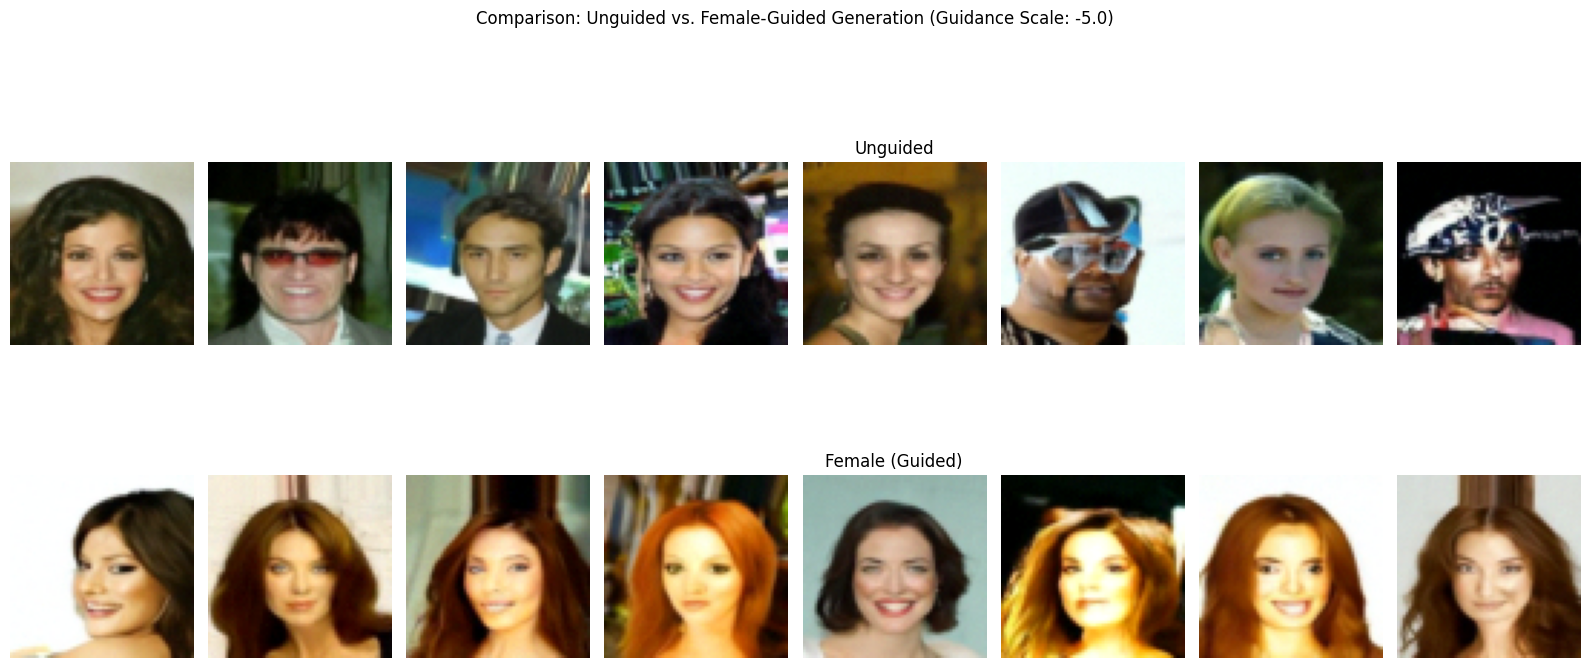

In [10]:
# Parameters for generating female faces
num_samples = 8
attribute_idx = 20  # Index for 'Male' attribute
guidance_strength = -5.0  # Negative guidance to push away from "Male" attribute (to generate females)
ddim_steps = 100  # Number of DDIM steps

print(f"Generating {num_samples} female faces with guidance scale {guidance_strength}...")

# Generate female faces using classifier guidance
guided_samples, generation_history = classifier_guided_sample_ddim_celeba(
    model=model,
    ddim_process=ddim_process,
    classifier=classifier,
    n_samples=num_samples,
    device=device,
    target_attr_idx=attribute_idx,  # 'Male' attribute index
    guidance_scale=guidance_strength,  # Negative to generate females
    N_ddim_steps=ddim_steps,
    eta=0.0  # Deterministic DDIM
)

# For comparison, generate unguided samples
unguided_samples = ddim_process.sample_ddim(
    model=model, 
    n_samples=num_samples, 
    device=device, 
    size=(3, 64, 64),
    timestep_subset=timestep_subset,
    eta=0.0
)

# Display comparison between guided (female) and unguided samples
plt.figure(figsize=(16, 8))

# Show unguided samples
for i in range(num_samples):
    plt.subplot(2, num_samples, i+1)
    img_unguided = (unguided_samples[i].permute(1, 2, 0) + 1) / 2
    plt.imshow(img_unguided.cpu().clamp(0, 1))
    plt.title("Unguided" if i == num_samples//2 else "")
    plt.axis('off')

# Show guided samples (female)
for i in range(num_samples):
    plt.subplot(2, num_samples, num_samples+i+1)
    img_guided = (guided_samples[i].permute(1, 2, 0) + 1) / 2
    plt.imshow(img_guided.clamp(0, 1))
    plt.title("Female (Guided)" if i == num_samples//2 else "")
    plt.axis('off')

plt.suptitle(f"Comparison: Unguided vs. Female-Guided Generation (Guidance Scale: {guidance_strength})")
plt.tight_layout()
plt.show()

Visualizing guided generation history...


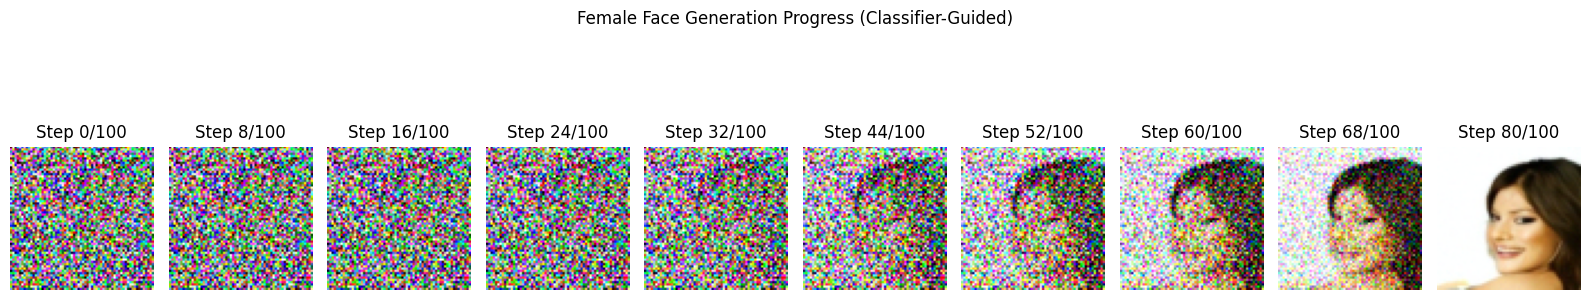

In [11]:
# Visualize the generation process of one guided sample
if generation_history:
    print("Visualizing guided generation history...")
    num_steps_to_show = min(10, len(generation_history))
    indices_to_show = np.linspace(0, len(generation_history)-1, num_steps_to_show, dtype=int)
    
    fig, axes = plt.subplots(1, num_steps_to_show, figsize=(16, 4))
    for i, idx in enumerate(indices_to_show):
        img_step = generation_history[idx]
        ax = axes[i]
        # Show the first image in the batch
        img_viz = (img_step[0].permute(1, 2, 0) + 1) / 2
        ax.imshow(img_viz.clamp(0, 1))
        ax.axis('off')
        step_num = idx * (ddim_steps // len(generation_history))
        ax.set_title(f"Step {step_num}/{ddim_steps}")
    
    plt.suptitle("Female Face Generation Progress (Classifier-Guided)")
    plt.tight_layout()
    plt.show()

Generating 4 samples with Smiling, guidance scale 3.0...


DDIM Classifier-Guided Sampling: 100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


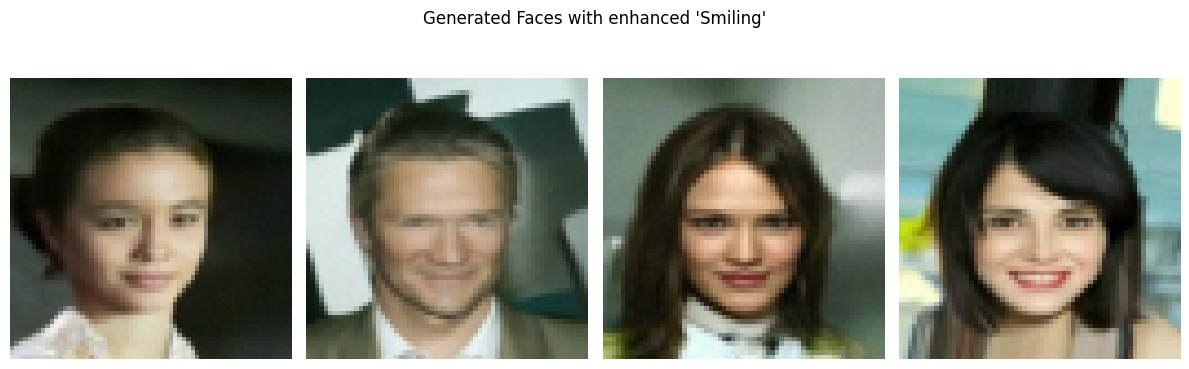

Generating 4 samples with Eyeglasses, guidance scale 3.0...


DDIM Classifier-Guided Sampling: 100%|██████████| 100/100 [00:08<00:00, 12.16it/s]


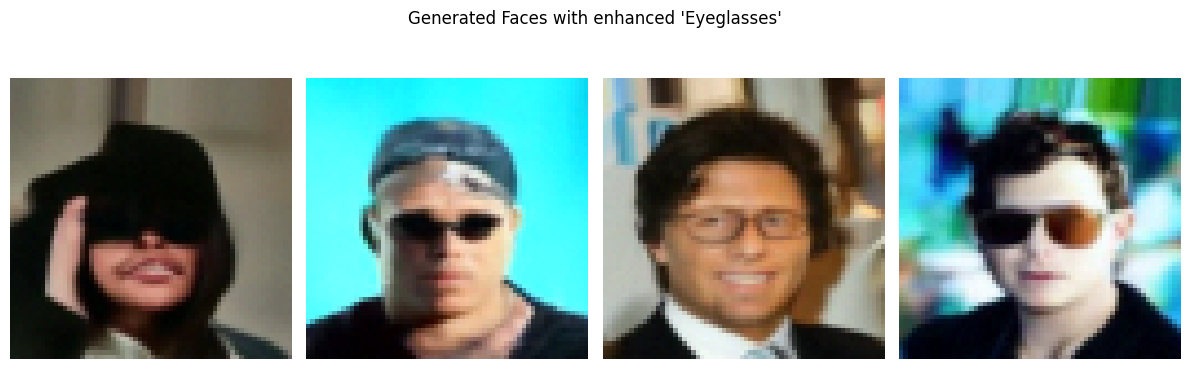

Generating 4 samples with Blond_Hair, guidance scale 3.0...


DDIM Classifier-Guided Sampling: 100%|██████████| 100/100 [00:08<00:00, 12.08it/s]


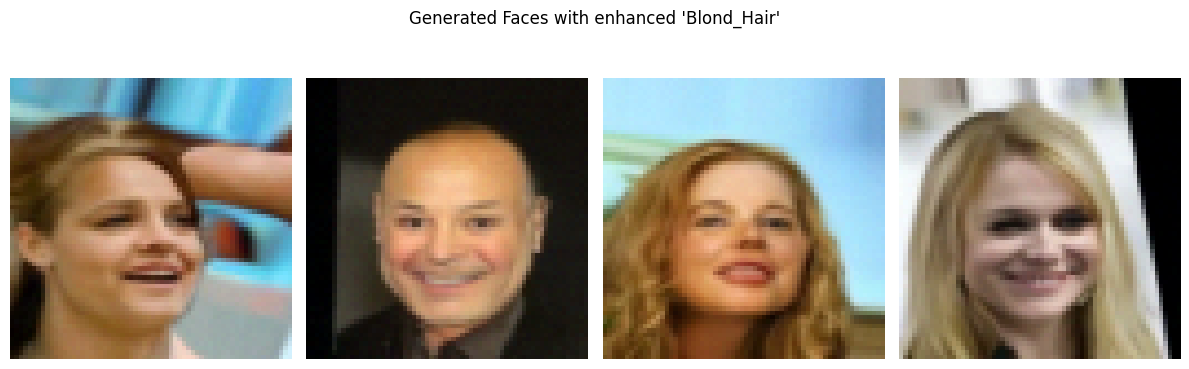

In [12]:
# Try generating faces with different attributes
def generate_with_attribute(attribute_name, guidance_strength=3.0, num_samples=4):
    # Find the index of the attribute
    attr_idx = dataset.attr_names.index(attribute_name) if attribute_name in dataset.attr_names else -1
    
    if attr_idx == -1:
        print(f"Attribute '{attribute_name}' not found in dataset.attr_names")
        return
    
    print(f"Generating {num_samples} samples with {attribute_name}, guidance scale {guidance_strength}...")
    
    # Generate samples with the specified attribute guidance
    guided_samples, _ = classifier_guided_sample_ddim_celeba(
        model=model,
        ddim_process=ddim_process,
        classifier=classifier,
        n_samples=num_samples,
        device=device,
        target_attr_idx=attr_idx,
        guidance_scale=guidance_strength,
        N_ddim_steps=100,
        eta=0.0
    )
    
    # Display the results
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img_guided = (guided_samples[i].permute(1, 2, 0) + 1) / 2
        plt.imshow(img_guided.clamp(0, 1))
        plt.axis('off')
    
    direction = "enhanced" if guidance_strength > 0 else "reduced"
    plt.suptitle(f"Generated Faces with {direction} '{attribute_name}'")
    plt.tight_layout()
    plt.show()

# Experiment with a few different attributes
attributes_to_try = [
    ("Smiling", 3.0),         # Generate smiling faces
    ("Eyeglasses", 3.0),      # Generate faces with glasses
    ("Blond_Hair", 3.0)       # Generate faces with blond hair
]

for attr_name, guidance_str in attributes_to_try:
    generate_with_attribute(attr_name, guidance_str)
